# Neural Network

## Read data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156016 entries, 0 to 156015
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   review  156016 non-null  object
 1   label   156016 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,review,label
0,what a game very good fun,1
1,The game is garbage now,0
2,game is good though ranked is full of entitled...,1
3,no,0
4,Played a bit it's alright,1


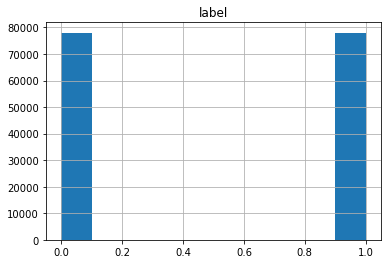

In [125]:
import pandas as pd

df_train = pd.read_json("../data/steam_train.json", orient="records")
df_train.info()
df_train.hist()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52004 entries, 0 to 52003
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  52004 non-null  object
 1   label   52004 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 812.7+ KB


,review,label
0,This game is addicting. Simple as that,1
1,Fun,1
2,good gamegood graphics,1
3,It's a amazing game!,1
4,Mods are what made this game. and they banned ...,0


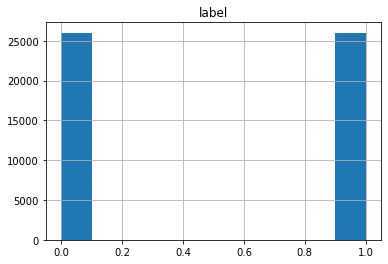

In [126]:
df_val = pd.read_json("../data/steam_val.json", orient="records")
df_val.info()
df_val.hist()
df_val.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52006 entries, 0 to 52005
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  52006 non-null  object
 1   label   52006 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 812.7+ KB


,review,label
0,very good game!,1
1,Probably the most overrated game to date. Lack...,0
2,Tis a good game lots of fun when you play with...,1
3,Its Gta kill a hooker or two.,1
4,Simply just so fun game to play...,1


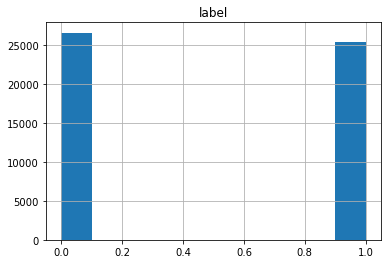

In [127]:
df_test = pd.read_json("../data/steam_test.json", orient="records")
df_test.info()
df_test.hist()
df_test.head()

## Preprocessing

In [128]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

STOPWORDS = stopwords.words("english")

def is_html_tag(word):
    w = word.replace("\n", "")
    return w.startswith("<") or w.startswith(">") or w.startswith("/") or w.strip()[:2] == "br"

def remove_html_tags(sentence):
    single_spaces = " ".join(sentence.split())

    return " ".join([token for token in single_spaces.split(" ") if not is_html_tag(token)])

def tokenize_sentence(sentence):
    return word_tokenize(sentence.lower())

def remove_stopwords(sentence):
    return " ".join([word for word in sentence.split(" ") if not word in STOPWORDS])

def remove_punctuation(tokenized_sentence):
    return [word for word in tokenized_sentence if word.isalpha()]

def preprocess(sentence):
    return remove_punctuation(tokenize_sentence(remove_stopwords(remove_html_tags(str(sentence)))))

print(preprocess(df_train["review"].values[1]))


['the', 'game', 'garbage']


In [129]:
def sentiment(value):
    if(value == 1):
        return "positive"
    else:
        return "negative"

df_train["sentiment"] = [None] * len(df_train)
df_train["sentiment"] = df_train["label"].apply(sentiment)
df_val["sentiment"] = [None] * len(df_val)
df_val["sentiment"] = df_val["label"].apply(sentiment)
df_test["sentiment"] = [None] * len(df_test)
df_test["sentiment"] = df_test["label"].apply(sentiment)

In [130]:
df_train["review"] = df_train["review"].apply(preprocess)
df_train.head()

,review,label,sentiment
0,"[game, good, fun]",1,positive
1,"[the, game, garbage]",0,negative
2,"[game, good, though, ranked, full, entitled, l...",1,positive
3,[],0,negative
4,"[played, bit, alright]",1,positive


In [131]:
def build_vocab(tokenized_input, vocab_size):
    d = dict()

    for tokens in tokenized_input:
        for token in tokens:
            # double check
            if token not in STOPWORDS and token.isalpha():
                d[token] = d.get(token, 0) + 1


    return {k for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)[:vocab_size]}

In [132]:
VOCAB_SIZE = 40000
VOCAB = build_vocab(df_train["review"].values, VOCAB_SIZE) # (!) Always build the vocabulary on the TRAIN dataset

In [133]:
def get_frequencies_for_sentiment(df):
    dict_freqs = {"positive": {}, "negative": {}}
    
    for idx in range(df.shape[0]):
        tokens = df_train.iloc[idx]["review"]
        sentiment = df_train.iloc[idx]["sentiment"]
        
        for token in tokens:
            if token in VOCAB:
                dict_freqs[sentiment][token] = dict_freqs[sentiment].get(token, 0) + 1
            
    return dict_freqs

In [134]:
frequency_table = get_frequencies_for_sentiment(df_train)
frequency_table["positive"]["happy"]

420

In [135]:
import numpy as np

def extract_features(frequency_table, tokens):
    positives = 0
    negatives = 0

    for t in tokens:
        positives += frequency_table["positive"].get(t, 0)
        negatives += frequency_table["negative"].get(t, 0)
    
    return pd.Series({"positives": positives, "negatives": negatives})

In [136]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = df_train["review"].apply(lambda tokens: extract_features(frequency_table, tokens))

X_train = scaler.fit_transform(X_train)
y_train = df_train["label"].values

In [137]:
X_train.shape

(156016, 2)

In [138]:
df_val["review"] = df_val["review"].apply(preprocess)
X_val = df_val["review"].apply(lambda tokens: extract_features(frequency_table, tokens))
X_val = scaler.transform(X_val)
y_val = df_val["label"].values

## Create model and train / validate

In [139]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# https://keras.io/api/optimizers/
# https://keras.io/api/optimizers/adam/
# https://keras.io/api/losses/
# https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
# https://keras.io/api/metrics/accuracy_metrics/
# https://keras.io/api/metrics/
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['binary_accuracy'])
              
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
_________________________________________________________________


In [140]:
h = model.fit(X_train,
              y_train,
              validation_data=(X_val, y_val),
              epochs=12)

Epoch 1/12
4876/4876 [==============================] - 6s 1ms/step - loss: 0.5547 - binary_accuracy: 0.7367 - val_loss: 0.5953 - val_binary_accuracy: 0.7662
Epoch 2/12
4876/4876 [==============================] - 8s 2ms/step - loss: 0.4926 - binary_accuracy: 0.7883 - val_loss: 0.5797 - val_binary_accuracy: 0.7696
Epoch 3/12
4876/4876 [==============================] - 7s 1ms/step - loss: 0.4913 - binary_accuracy: 0.7871 - val_loss: 0.5843 - val_binary_accuracy: 0.7687
Epoch 4/12
4876/4876 [==============================] - 7s 1ms/step - loss: 0.4914 - binary_accuracy: 0.7881 - val_loss: 0.5838 - val_binary_accuracy: 0.7601
Epoch 5/12
4876/4876 [==============================] - 8s 2ms/step - loss: 0.4916 - binary_accuracy: 0.7878 - val_loss: 0.5895 - val_binary_accuracy: 0.7430
Epoch 6/12
4876/4876 [==============================] - 7s 1ms/step - loss: 0.4901 - binary_accuracy: 0.7891 - val_loss: 0.5817 - val_binary_accuracy: 0.7624
Epoch 7/12
4876/4876 [==============================

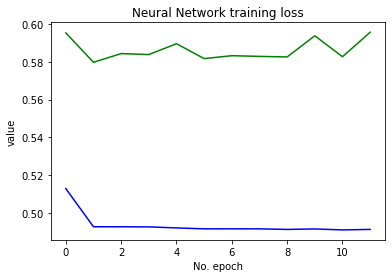

In [141]:
import matplotlib.pyplot as plt

plt.plot(h.history['loss'], label='(training data)',color='blue')
plt.plot(h.history['val_loss'], label='(validation data)',color='green')
plt.title('Neural Network training loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

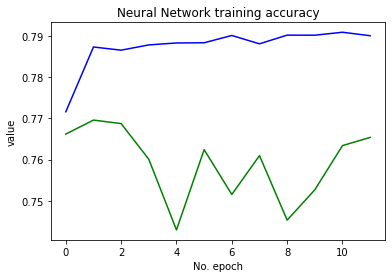

In [142]:
import matplotlib.pyplot as plt

plt.plot(h.history['binary_accuracy'], label='(training data)',color='blue')
plt.plot(h.history['val_binary_accuracy'], label='(validation data)',color='green')
plt.title('Neural Network training accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

## Evaluate the trained model

In [143]:
df_test["review"] = df_test["review"].apply(preprocess)
X_test = df_test["review"].apply(lambda tokens: extract_features(frequency_table, tokens))
X_test = scaler.transform(X_test)
y_test = df_test["label"].values

In [144]:
results = model.evaluate(X_test, y_test, batch_size=100)
print("test loss, test acc:", results)

521/521 [==============================] - 1s 942us/step - loss: 0.8573 - binary_accuracy: 0.6862
test loss, test acc: [0.8572505712509155, 0.6861900687217712]


In [145]:
df_test_raw = pd.read_json("../data/steam_test.json", orient="records")

In [149]:
predictions = np.round(model.predict(X_test[:5]),0)
for i in range(len(predictions)):
    print(df_test_raw["review"].values[i][:100],"...")
    print("Pred: ", predictions[i][0], "Real: ", y_test[i])

very good game! ...
Pred:  1.0 Real:  1
Probably the most overrated game to date. Lacks content months after EA release. Daily server proble ...
Pred:  0.0 Real:  0
Tis a good game lots of fun when you play with freinds but what were you smoking when you thought of ...
Pred:  1.0 Real:  1
Its Gta kill a hooker or two. ...
Pred:  0.0 Real:  1
Simply just so fun game to play... ...
Pred:  1.0 Real:  1
